# Metric for evaluating difference between seismograms

This notebook introduces metric for evaluating difference between seismograms and studies how it works for wery simple examples

More complex cases are considered in following notebooks

1. [Metric validation on simple synthetics data](./simple_synthetics_study.ipynb)
1. [Metric validation on synthetic seismogram and noise](./synthetic_noise_modelling.ipynb)
1. [Metric comparison with expert asessment. Dataset 1](./Metrics_validation.ipynb)
1. [Metric comparison with expert asessment. Dataset 2](./Metrics_validation_2.ipynb)
1. [Metrics Validation. Dataset with 2 Lifts. Base lift for metrics calculation is the one on which models were trained](./metrics_validation_3_multiple_lift.ipynb)
1. [Metrics Validation. Dataset with 2 Lifts. Base lift for metrics calculation is new lift](./metrics_validation_3_multiple_lift_base_v1.ipynb)


In [1]:
import sys
sys.path.append('..')

from functools import reduce

import numpy as np
from scipy import signal

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot

from utils import get_cv, draw_modifications_dist, get_modifications_list

### Computing Metrics

**Difference between two seismograms** with equal traces and timestamps number is computed as follows

* Choose 10% of traces with smallest offsets
* Get short-time Fourier transform for each trace for both seismograms
* For each window shift and corresponding traces compute power spectra difference as
$$
Dist(A_1, A_2) = \sum_{f}\left|{A_{1}[f]-A_{2}[f]}\right|
$$
* Resulting value is average over all traces and all window shifts

![Seismogram difference metrics](Seismogram_difference_metrics.png)

## Asessing on Normal Noise

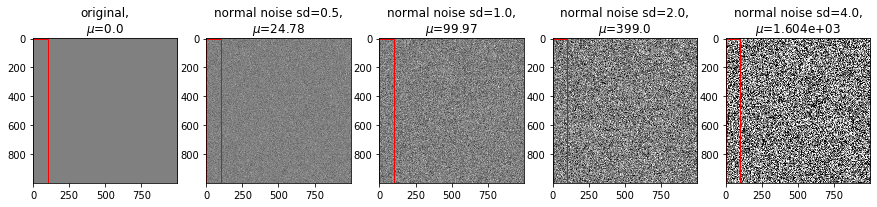

In [2]:
origin_shape = (1000, 1000)
origin = np.zeros(shape=origin_shape)
modifications = [(origin, "original")]
for i in range(1,5):
    mod = origin + np.random.normal(scale=2**i/4, size=origin_shape)
    modifications.append((mod, "normal noise sd={}".format(2**i/4)))
                         
draw_modifications_dist(modifications, vmin=-6, vmax=6, fontsize=12)    

## Seismograms with synthetic noise

### Loading Data

In [3]:
!ls /data

gpn_attention_model_output  multiple_lift_4_metrics_validation	synthetics3
metrics_study_ibm_output    Readme				YL1_UKM
Metric_study2		    symthetic_4_metrics_study.zip
Metrix_QC		    synthetic_4_metrics_study


In [4]:
base_path = '/data/gpn_attention_model_output/'
raw = np.load(base_path+'raw_1.npy')
lift = np.load(base_path+'lift_1.npy')
out = np.load(base_path+'out_1.npy')
att = np.load(base_path+'att_1.npy')

att = 1-att

cv = get_cv([raw])

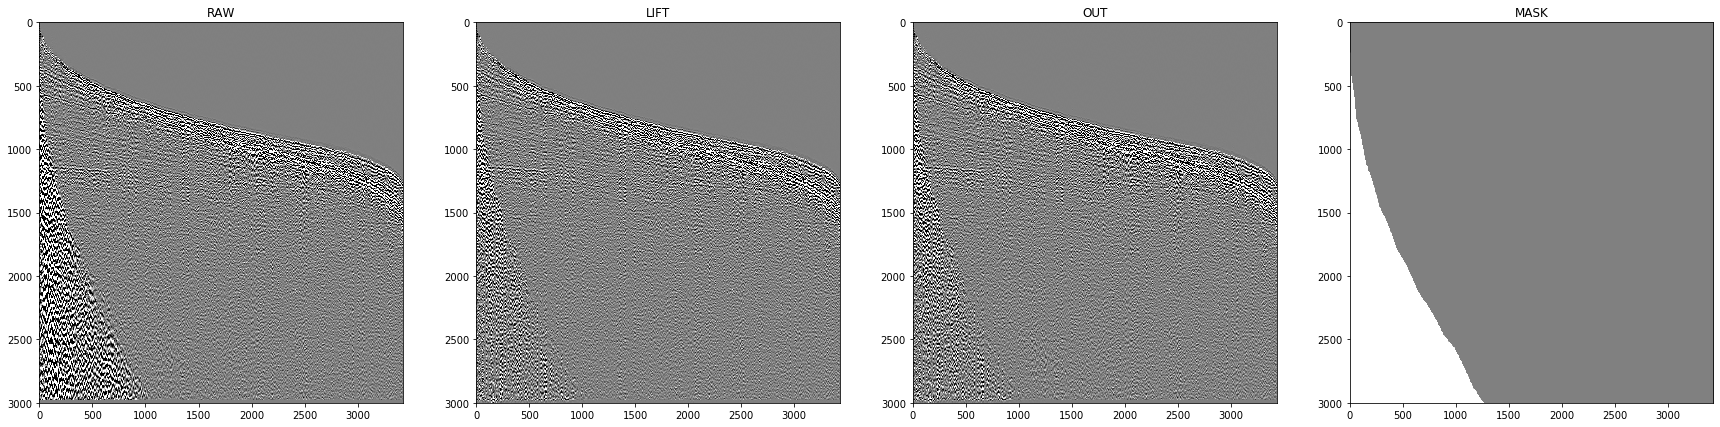

In [5]:
seismic_plot([raw, lift, out, att], figsize=(30, 7), names=['RAW', 'LIFT', 'OUT', 'MASK'], cmap='gray', vmin=-cv, vmax=cv)

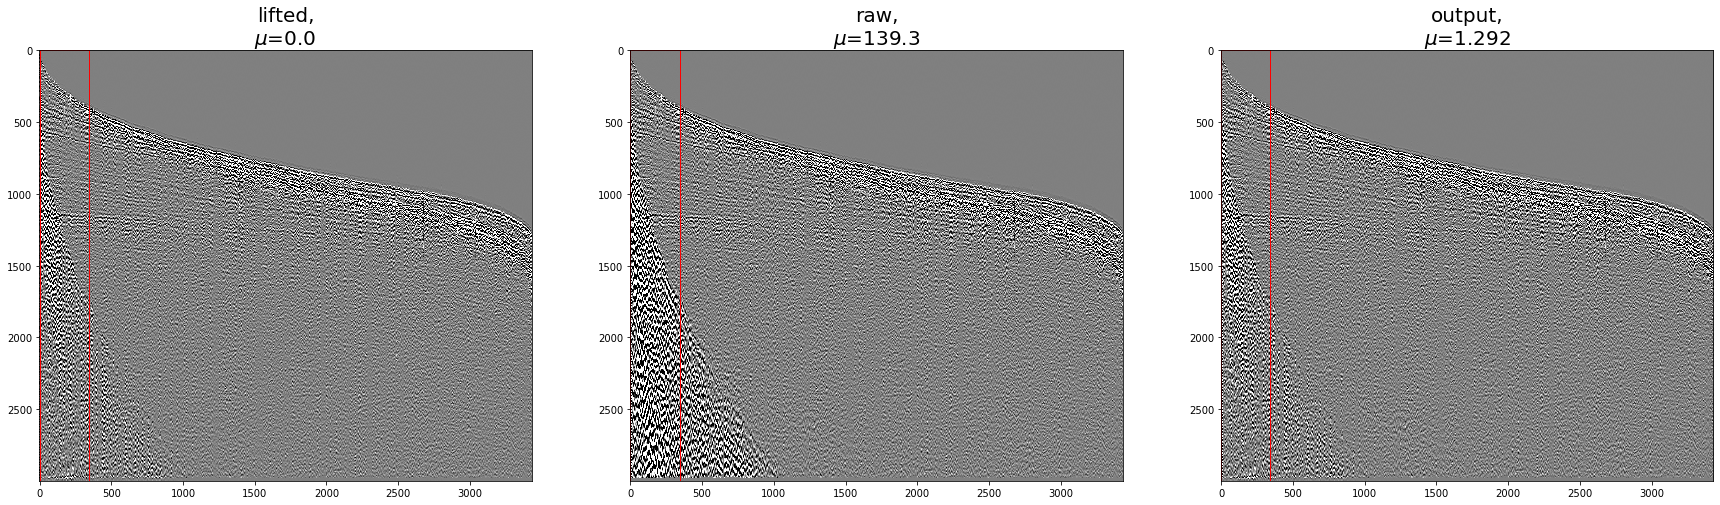

In [6]:
modifications = [(lift, "lifted"), (raw, "raw"), (out, "output")]

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 10))    

### Noise from difference between raw and lift

We compute the difference between raw and lift and clear all data outside ground roll area
Then we add this noise to lift

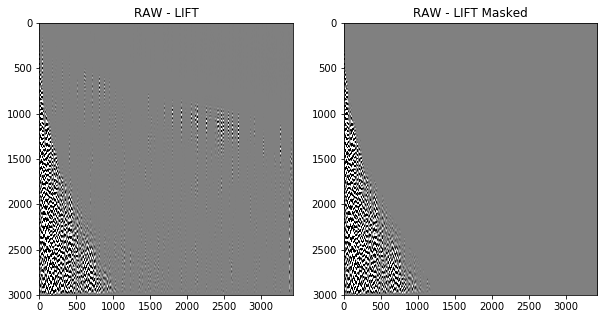

In [7]:
diff = raw - lift
diff_m = diff * att

seismic_plot([diff, diff_m], figsize=(10, 5), names=['RAW - LIFT', 'RAW - LIFT Masked'], cmap='gray', vmin=-cv, vmax=cv)

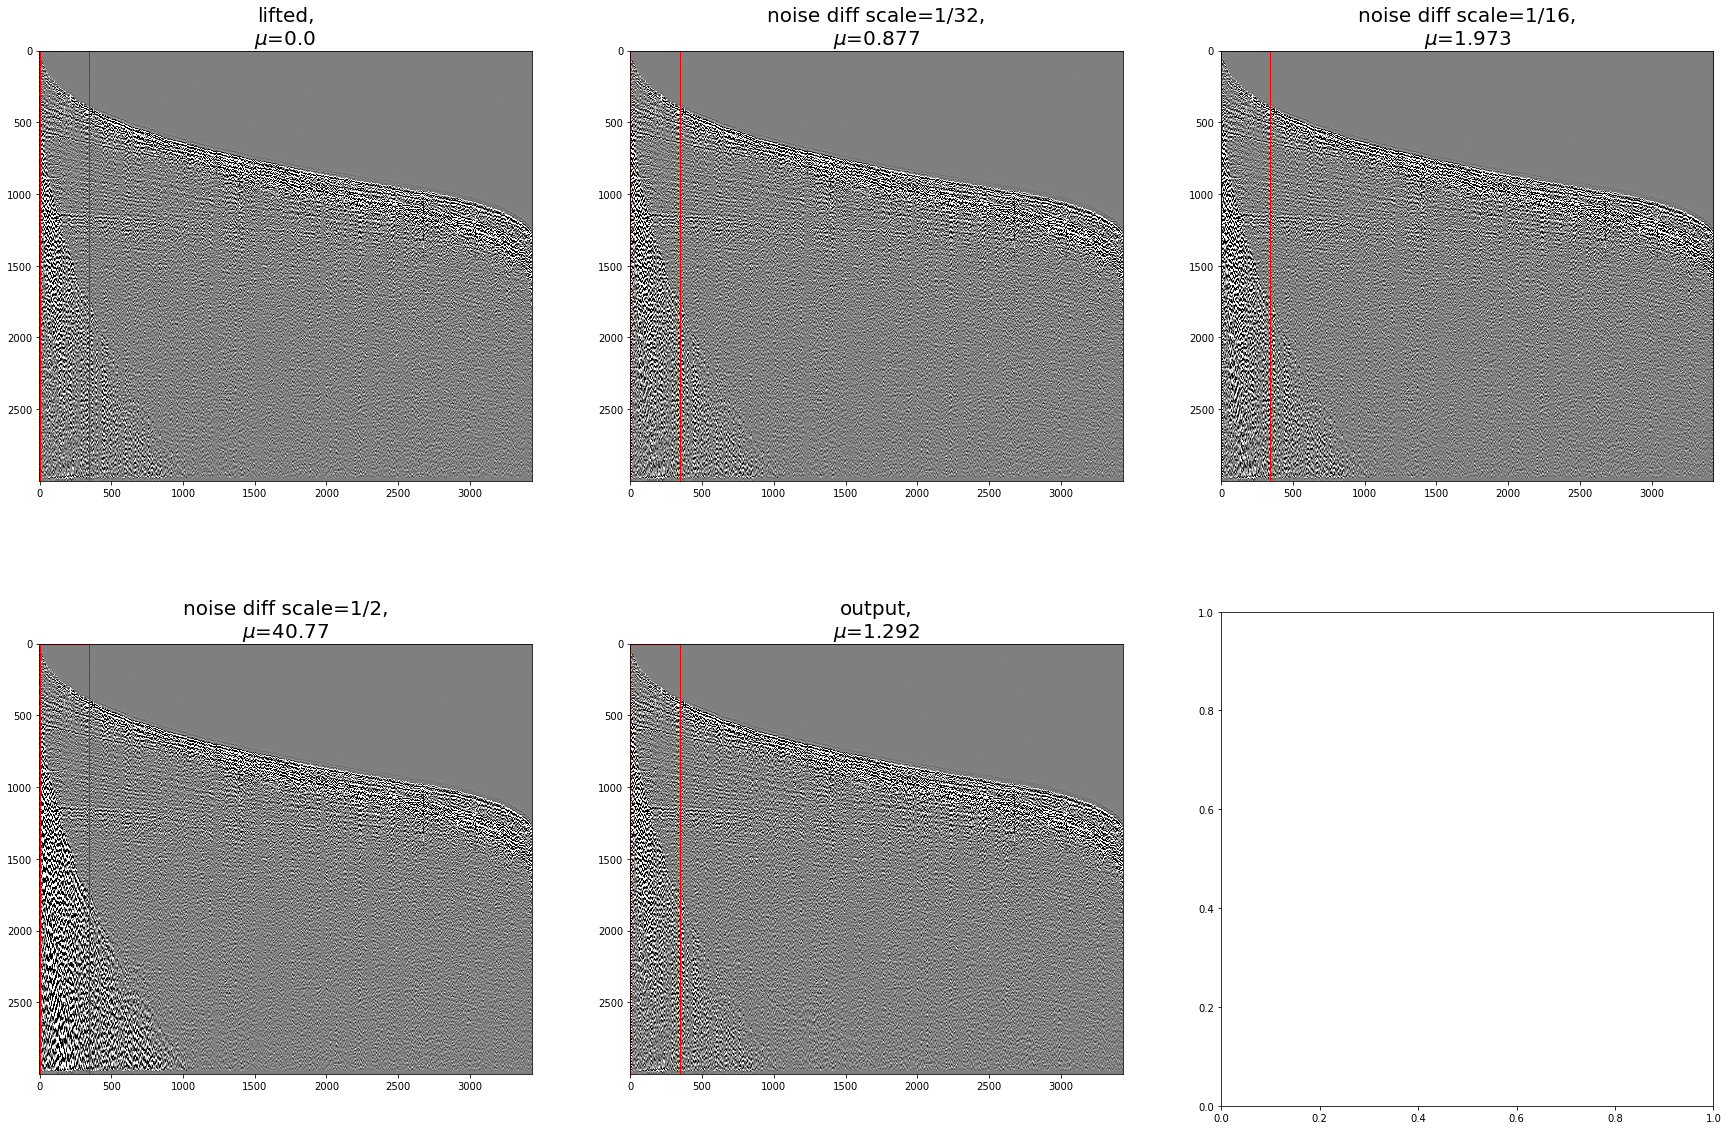

In [8]:
modifications = [(lift, "lifted")]

for scale in (32, 16, 2):
    mod = lift + diff_m / scale
    modifications.append((mod, "noise diff scale=1/{}".format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 20), n_cols=3)    

### Normal noise inside ground roll area

We add normal noise to lift inside ground roll area 

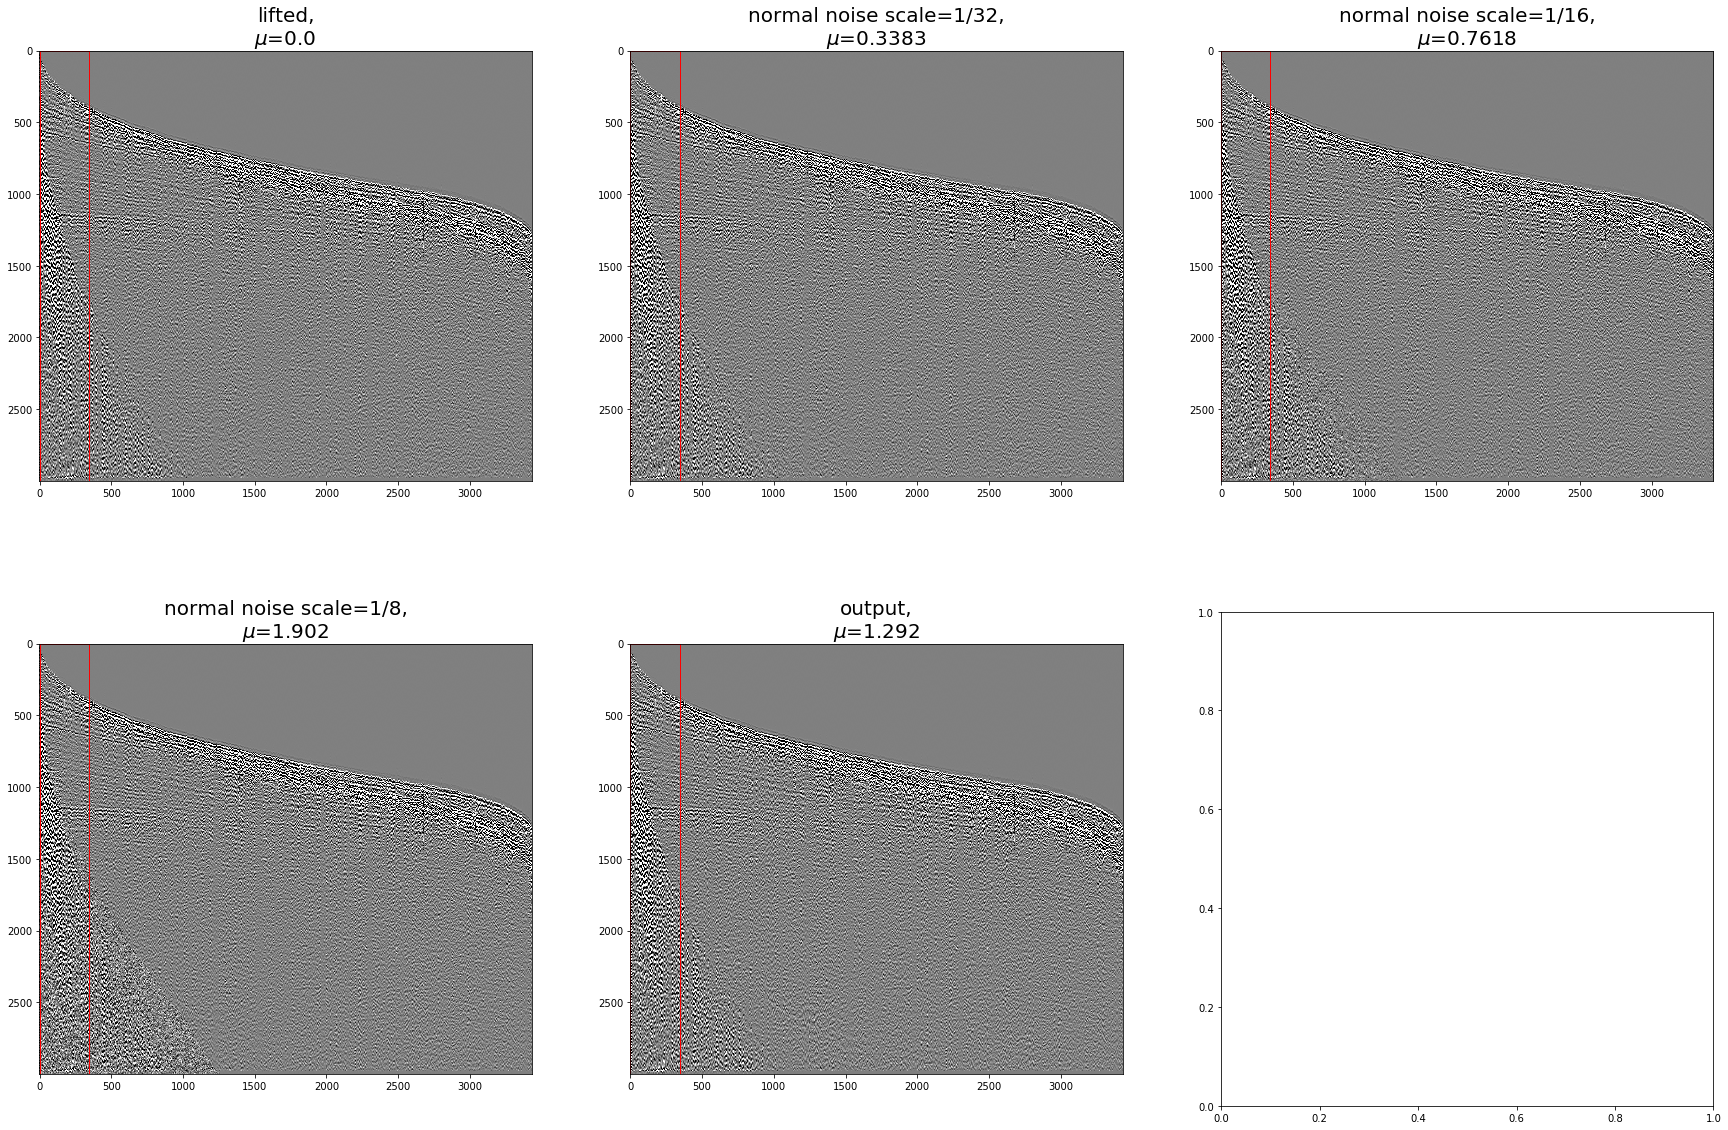

In [9]:
modifications = [(lift, "lifted")]

for scale in (32, 16, 8):
    mod = lift + np.random.normal(scale=1/scale, size=raw.shape) * att
    modifications.append((mod, "normal noise scale=1/{}".format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 20), n_cols=3)    

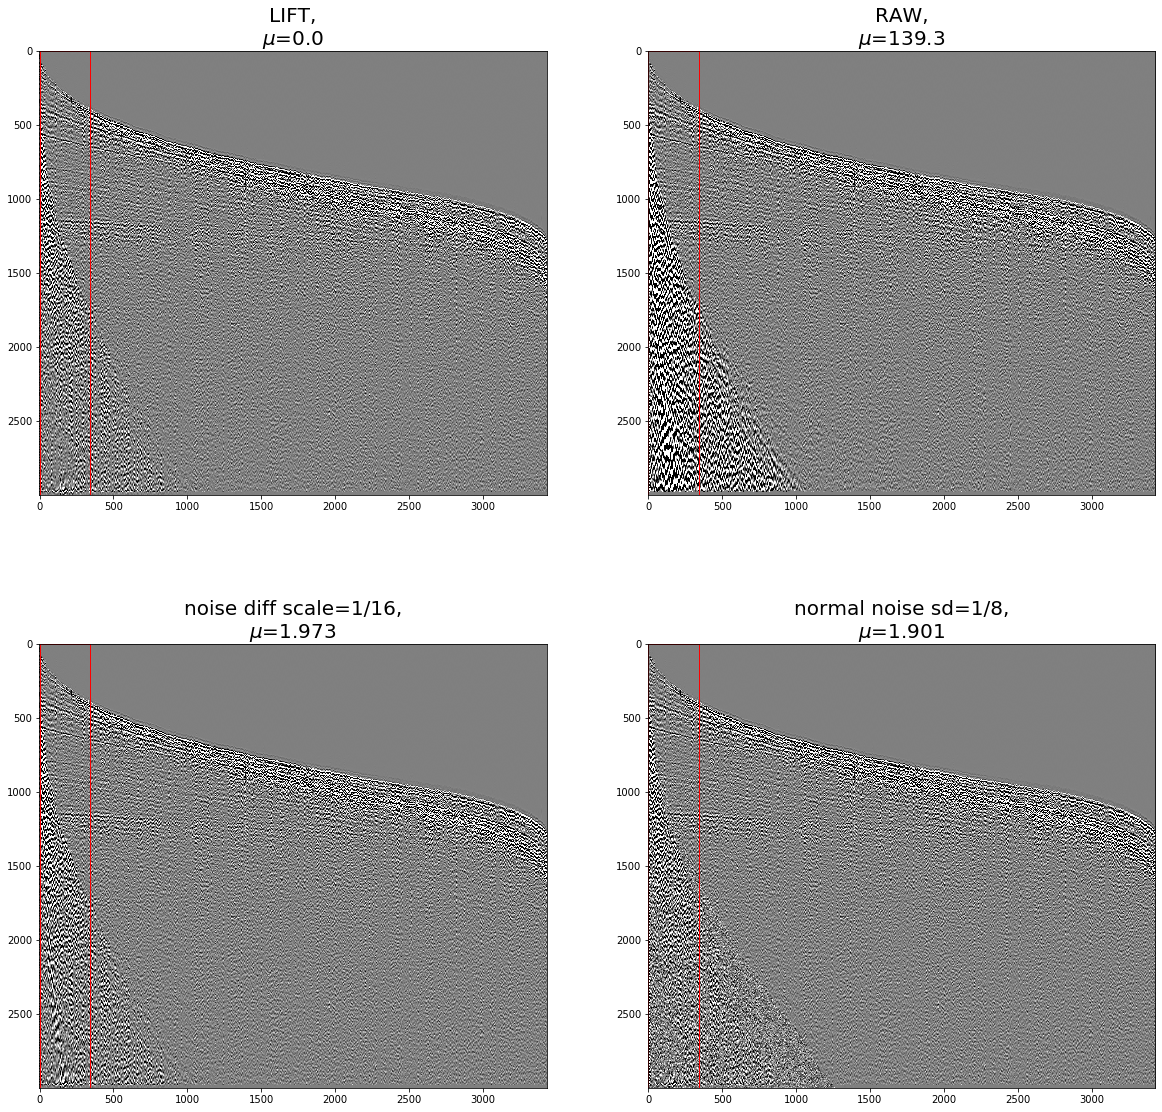

In [12]:
modifications = [(lift, "LIFT")]
modifications.append((raw, "RAW"))

mod = lift + diff_m / 16
modifications.append((mod, "noise diff scale=1/16"))

mod = lift + np.random.normal(scale=1/8, size=raw.shape) * att
modifications.append((mod, "normal noise sd=1/8"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(20, 20), n_cols=2, 
                        save_to='/home/antonina/winhome/misc/article_metric/synt_noise.png')    

### Normal noise in spectrum inside ground roll area

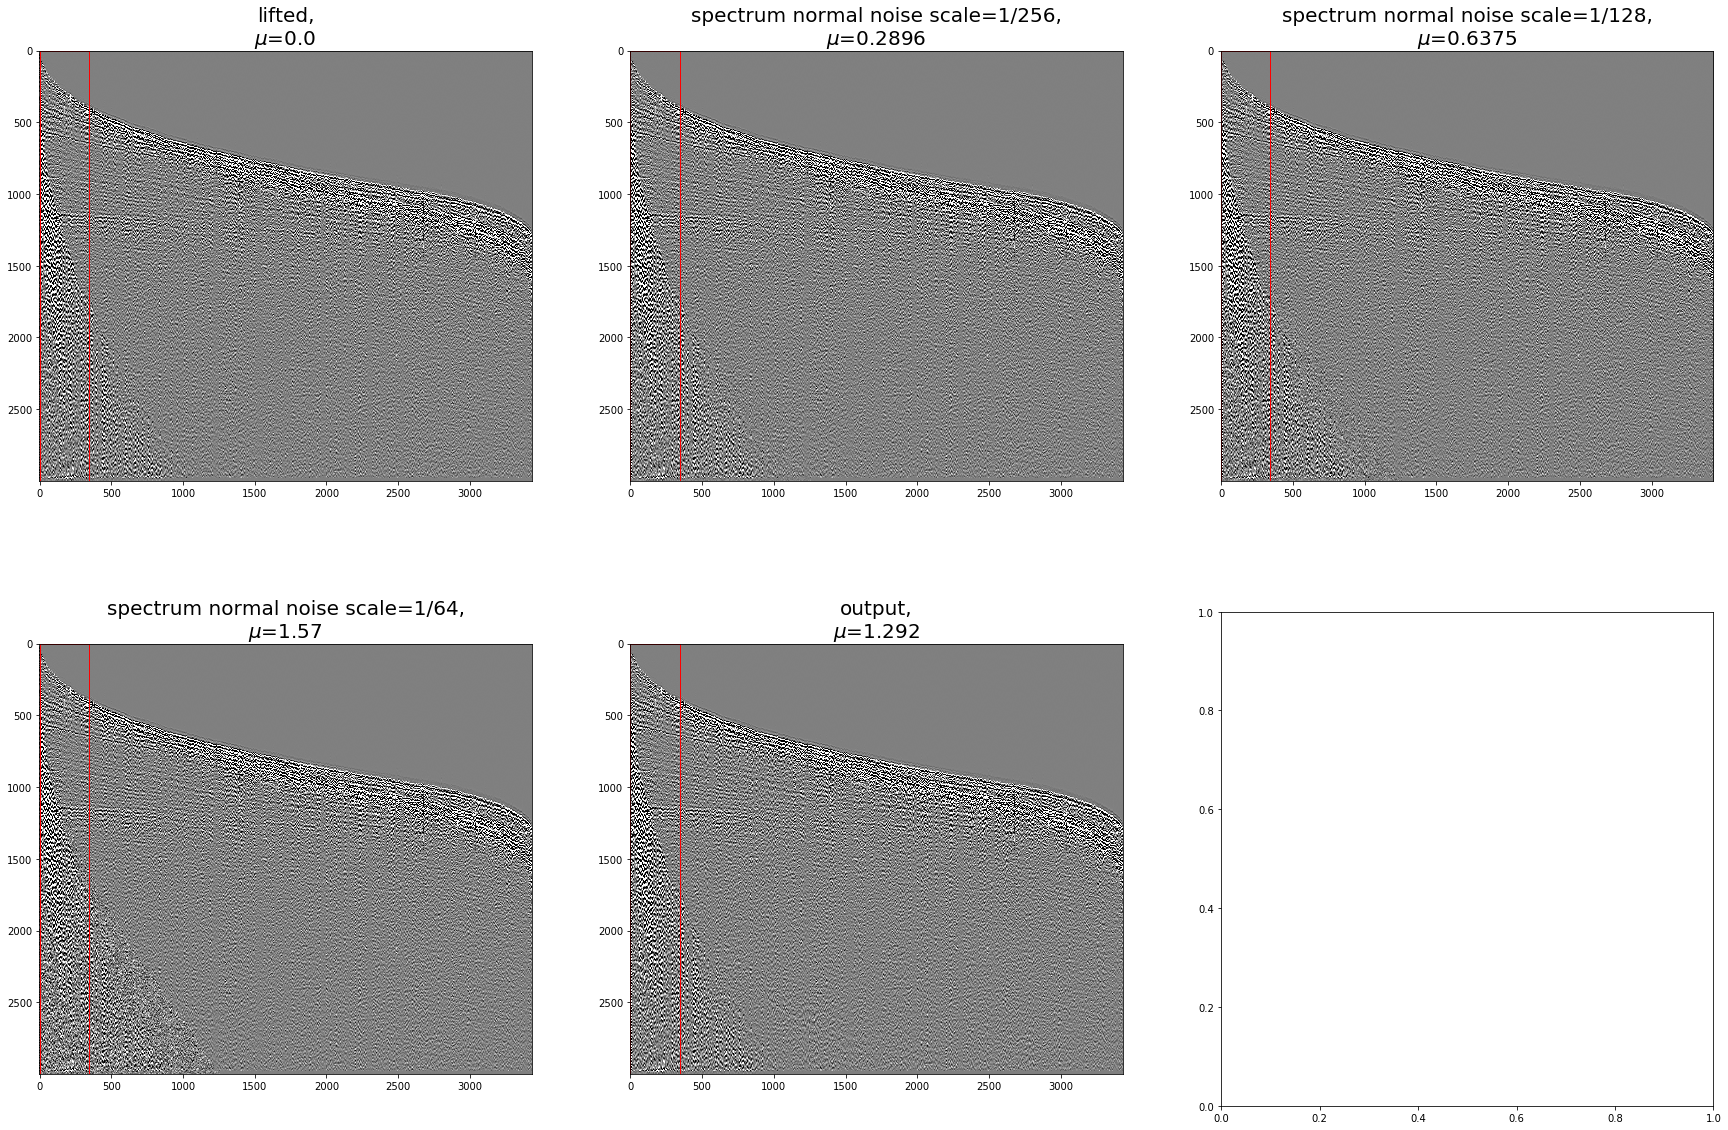

In [11]:
kwargs = dict(nperseg=100, noverlap=None, window='boxcar')
f, t, Zxx = signal.stft(lift, **kwargs)

modifications = [(lift, "lifted")]
for scale in (256, 128, 64):  
    Zxx_n = Zxx + np.random.normal(scale=1/scale, size=Zxx.shape)
    _, lift_restored = signal.istft(Zxx_n, **kwargs)
    lift_restored = lift * (1 - att) + lift_restored * att
    modifications.append((lift_restored, 'spectrum normal noise scale=1/{}'.format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, figsize=(30, 20), n_cols=3)